In [1]:
import torch, torchvision, cv2, PIL, os, random, time
import numpy as np
import pandas as pd
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device : {device}")

Device : cuda


In [3]:
total_train_pd = pd.read_csv(f"C:/Users/PC00/Desktop/Puzzle/train.csv")
total_test_pd = pd.read_csv(f"C:/Users/PC00/Desktop/Puzzle/test.csv")

# img_path 불러오기
pd_train_ID = total_train_pd["ID"]
pd_test_ID = total_test_pd["ID"]

# ID, img_path 제거하고 label만 남기기
pd_train_label = total_train_pd.drop(['ID', 'img_path'], axis=1)

print(f"Train_ID[0]: {pd_train_ID.iloc[0]}")

# 행 단위로 Label data 읽어오기
print(f"Train_Label[0]: {pd_train_label.iloc[0].to_numpy()}")

Train_ID[0]: TRAIN_00000
Train_Label[0]: [ 8  1 16 12  5 10 14  2 13  4  7  3  6  9 11 15]


In [4]:
def label_to_numpy(total_label):
    length = len(total_label)
    label = []

    for i in range(length):
        label.append(total_label.iloc[i].to_numpy())
    
    return np.array(label)

In [5]:
train_label = label_to_numpy(pd_train_label)
print(f"TRAIN_LABEL_SIZE: {train_label.shape}")

TRAIN_LABEL_SIZE: (70000, 16)


In [6]:
def img_path_list(ID, train):
    path = f"C:/Users/PC00/Desktop/Puzzle/"
    img_path = []
    size = len(ID)

    if train is True:
        path = f"{path}train/"
        for i in range(size):
            img_path.append(f"{path}{ID[i]}.jpg")
    else:
        path = f"{path}test/"
        for i in range(size):
            img_path.append(f"{path}{ID[i]}.jpg")
    
    return img_path

In [7]:
train_img_path = img_path_list(pd_train_ID, True)
print(f"No. of TRAIN IMAGES: {len(train_img_path)}")
print(f"TRAIN_IMG_PATH[0]: {train_img_path[0]}")

No. of TRAIN IMAGES: 70000
TRAIN_IMG_PATH[0]: C:/Users/PC00/Desktop/Puzzle/train/TRAIN_00000.jpg


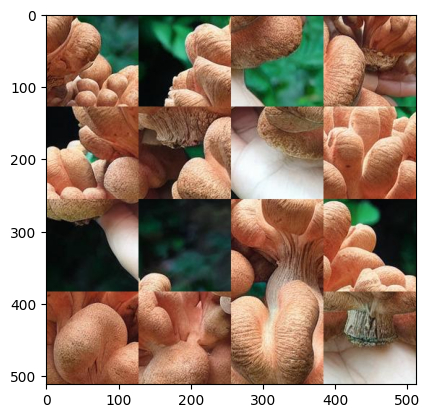

In [8]:
# Sample 이미지 -> TRAIN_00000
sample = PIL.Image.open(train_img_path[0])
plt.imshow(sample)

In [9]:
preprocessing = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [10]:
class CustomDataset(Dataset):
    def __init__(self, path, label, transform):
        self.path = path
        self.label = label
        self.transform = transform
    
    def __len__(self):
        return len(self.path)
    
    def __getitem__(self, idx):
        path = self.path[idx]
        label = self.label[idx]
        img = PIL.Image.open(path)

        if self.transform is not None:
            img = self.transform(img)
        
        return img, torch.from_numpy(label)

In [11]:
train_dataset = CustomDataset(train_img_path, train_label, transform=preprocessing)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [12]:
f, l = next(iter(train_dataloader))
print(f[0].shape)
print(l[0].shape)

torch.Size([3, 224, 224])
torch.Size([16])


In [13]:
from Vision_Transformer import ViT

In [14]:
model = ViT(image_size=224, patch_size=56, num_classes=16, dim=64, depth=4, heads=8, mlp_dim=16).to(device)
model

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=56, p2=56)
    (1): LayerNorm((9408,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=9408, out_features=6, bias=True)
    (3): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (transformer): Transformer(
    (norm): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-3): 4 x ModuleList(
        (0): Attention(
          (norm): LayerNorm((6,), eps=1e-05, elementwise_affine=True)
          (attend): Softmax(dim=-1)
          (dropout): Dropout(p=0.0, inplace=False)
          (to_qkv): Linear(in_features=6, out_features=1536, bias=False)
          (to_out): Sequential(
            (0): Linear(in_features=512, out_features=6, bias=True)
            (1): Dropout(p=0.0, inplace=False)
          )
        )
        (1): FeedForward(
          (net): Sequential(
            (0): LayerNo

In [15]:
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

In [16]:
def train_loop(model, dataloader, loss_fn, optimizer, scheduler, model_save_path):
    model.train()

    size = len(dataloader)
    datasize = len(dataloader.dataset)

    loss_hist, acc_hist = [], []

    for epoch in range(10):
        epoch_start = time.time()

        loss_item=0
        correct=0
        print(f"Start epoch : {epoch+1}")
        for batch, (X,y) in enumerate(dataloader):
            X = X.to(device).float()
            y = y.to(device).float()

            output = model(X)

            loss = loss_fn(output, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_item += loss.item()

            correct+=(output==y).detach().cpu().sum().item()

            if batch % 20 == 0:
                print(f"Batch loss : {(loss/size):>.5f} {batch}/{size}")

        loss_hist.append(loss_item/size)
        acc_hist.append(correct/datasize*100)

        print(f"Loss : {(loss_item/size):>.5f} ACC : {(correct/datasize*100):>.2f}%")

        epoch_end = time.time()
        print(f"End epoch : {epoch+1}")
        print(f"Epoch time : {(epoch_end-epoch_start)//60} min {(epoch_end-epoch_start)%60} sec")
        print()

    torch.save(model.state_dict(), model_save_path)

    return loss_hist, acc_hist

In [17]:
loss_hist, acc_hist = train_loop(model, train_dataloader, loss_fn, optimizer, scheduler, model_save_path=f"/home/user1/바탕화면/DACON 퍼즐/model_save_path/vit1.pt")

Start epoch : 1
Batch loss : 0.36467 0/1094
Batch loss : 0.35867 20/1094
Batch loss : 0.35769 40/1094
Batch loss : 0.35497 60/1094
Batch loss : 0.35340 80/1094
Batch loss : 0.35180 100/1094
Batch loss : 0.35258 120/1094
Batch loss : 0.35166 140/1094
Batch loss : 0.35196 160/1094
Batch loss : 0.35198 180/1094
Batch loss : 0.35114 200/1094
Batch loss : 0.35085 220/1094
Batch loss : 0.34942 240/1094
Batch loss : 0.34969 260/1094
Batch loss : 0.34998 280/1094
Batch loss : 0.34914 300/1094
Batch loss : 0.34905 320/1094
Batch loss : 0.34904 340/1094
Batch loss : 0.34808 360/1094
Batch loss : 0.34893 380/1094
Batch loss : 0.34907 400/1094
Batch loss : 0.34787 420/1094
Batch loss : 0.34743 440/1094
Batch loss : 0.34763 460/1094
Batch loss : 0.34800 480/1094
Batch loss : 0.34797 500/1094
Batch loss : 0.34774 520/1094
Batch loss : 0.34678 540/1094
Batch loss : 0.34692 560/1094
Batch loss : 0.34619 580/1094
Batch loss : 0.34630 600/1094
Batch loss : 0.34673 620/1094
Batch loss : 0.34705 640/1094


KeyboardInterrupt: 